In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
import cv2
import glob
import pickle
from tqdm import tqdm
%matplotlib inline

In [2]:
################################################ [TODO] ###################################################
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3, padding=(1,1)), #(channel in, channel out, filter)
            nn.BatchNorm2d(out_ch), # Channels in
            nn.Tanh(), #Channel in
        )

    def forward(self, x):
        x = self.conv(x) 
        
        return x

In [3]:
################################################ [TODO] ###################################################
# DEFINE DOWN CLASS
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.down = nn.MaxPool2d(2,stride=1) # use nn.MaxPool2d( )
        self.conv = single_conv(in_ch,out_ch) # use previously defined single_cov
    def forward(self, x):
        x = self.down(x)
        x = self.conv(x)
        return x
    

################################################ [TODO] ###################################################
# DEFINE UP CLASS
# Note that this class will not only upsample x1, but also concatenate up-sampled x1 with x2 to generate the final output

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()       
        self.up = nn.Upsample(scale_factor=2, mode='bilinear') # use nn.Upsample( )
        self.conv = single_conv(in_ch,out_ch) # use previously defined single_cov

    def forward(self, x1, x2):
        # This part is tricky, so we provide it for you
        # First we upsample x1
        x1 = self.up(x1)
            
        # Notice that x2 and x1 may not have the same spatial size. 
        # This is because when you downsample old_x2(say 25 by 25), you will get x1(12 by 12)   
        # Then you perform upsample to x1, you will get new_x1(24 by 24)
        # You should pad a new row and column so that new_x1 and x2 have the same size.
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # Now we concatenat x2 channels with x1 channels
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

################################################ [TODO] ###################################################
# DEFINE OUTCONV CLASS
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv =nn.Conv2d(in_ch,out_ch,3,padding=(1,1)) # Use nn.Conv2D( ) since we do not need to do batch norm and relu at this layer

    def forward(self, x):
        x = self.conv(x)
        return x

In [4]:
class UNet0(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet0, self).__init__()
        self.inc = single_conv(n_channels, 16) # conv2d +  batchnorm + Tanh 
        self.down1 = single_conv(16, 32)              # maxpool2d + conv2d + batchnorm + Tanh
        #self.down2 = single_conv(32, 16)              # maxpool2d + conv2d + batchnorm + tanh
        self.up1 = single_conv(32,16)                   # upsample + pad + conv2d + batchnorm + tanh
        self.up2 = single_conv(16,8)                   # upsample + pad + conv2d + batchnorm + tanh
        self.up3 =nn.Sequential(
            nn.Conv2d(8,3,3, padding=(1,1)), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
        self.fc1 = nn.Linear(20*20*8, 20*20*3)
    def  forward(self, x):
        x = self.inc(x) #16x16x3e
        x = self.down1(x) #8x8x4
        #x = self.down2(x) #4x4x6
        x = self.up1(x) #4x4x6
        x = self.up2(x) #8x8x4
        x = self.up3(x)
        x = torch.relu(x)
        return x    

In [5]:
class UNet1(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet1, self).__init__()
        self.inc = single_conv(n_channels, 16) # conv2d +  batchnorm + relu
        self.down1 = down(16, 32)         # maxpool2d + conv2d + batchnorm + relu
        self.down2 = down(32,32)                 # maxpool2d + conv2d + batchnorm + relu

        self.up1 = up(64,16)                    # upsample + pad + conv2d + batchnorm + relu
        self.up2 = up(32,16)                    # upsample + pad + conv2d + batchnorm + relu

        self.outc = outconv(16,3)                   # conv2d

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x = self.up1(x3, x2)
        x = self.up2(x,x1)

        x = self.outc(x)
        return F.tanh(x)
    

In [6]:
################################################ [TODO] ###################################################
# define dice coefficient 
class MseCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, input, target):
        self.save_for_backward(input, target)
        ################################################ [TODO] ###################################################
        # Calculate intersection and union. 
        # You can convert the input image into a vector with input.contiguous().view(-1)
        # Then use torch.dot(A, B) to calculate the intersection.
        # Use torch.sum(A) to get the sum.
        input = input.contiguous().view(-1)
        target = target.contiguous().view(-1)
        # Calculate Mean Squared Error
        diff = input - target;
        dot =  torch.dot(diff,diff)
        dot = dot/input.numel()
        return dot


################################################ [TODO] ###################################################
# Calculate dice coefficients for batches
def mse_coeff(input, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()    
    # For each pair of input and target, call DiceCoeff().forward(input, target) to calculate dice coefficient
    # Then average
    MSE = MseCoeff()
    for i, (c, b) in enumerate(zip(input, target)):
        s += MSE.forward(c,b);
    s = s / (i + 1)
    return s

def grad(input):
    x_right = F.pad(input, (0, 1, 0, 0))
    x_left = F.pad(input, (1, 0, 0, 0 ))
    y_up =   F.pad(input, (0, 0, 1, 0 )) 
    y_down =   F.pad(input, (0, 0, 0,1))
    dx = x_right - x_left;
    dy = y_up - y_down;
    return dx[:,1:20, 1:20], dy[:,1:20, 1:20]

def grad_loss(input, target, epoch):
    s = torch.FloatTensor(1).zero_()    
    # For each pair of input and target, call DiceCoeff().forward(input, target) to calculate dice coefficient
    # Then average
   # print(input.shape)
   # print(target.shape)
    MSE = MseCoeff()
    s = 0;
    if epoch == 0:
        p,q,r = 0.8, 0.2, 0.2
    elif epoch == 1: 
        p,q,r  = 0.6, 0.4, 0.4
    elif epoch ==2:
        p,q,r  = 0.4,0.6, 0.6
    else:
        p,q,r = 0.2,0.8,0.8
    for i, (c, b) in enumerate(zip(input, target)): 
        Gx_in , Gy_in = grad(c)
        Gx_target, Gy_target = grad(b)
        s += p*MSE.forward(c,b);
        s += q*MSE.forward(Gx_in,Gx_target);
        s += r*MSE.forward(Gy_in, Gy_target);
    s = s / (i+1)
    return s

In [7]:
validation_20 = glob.glob('./Data/Validation/validation_20')
train_20 = glob.glob('./Data/Train/train_20')
test_20 = glob.glob('./Data/Test/test_20')
valiDataset_20 = []
trainDataset_20 = []
testDataset_20 = []
#Loads the following in a list of (3, 16,16) and (3, 20,20)
for i in range(len(validation_20)):
    f=open(validation_20[i],'rb')
    b=pickle.load(f)
    #flip the data dimension
    b = np.transpose(b, axes=[3, 2, 0, 1])
    f.close()
    valiDataset_20.append(b)
    
for i in range(len(test_20)):
    f=open(test_20[i],'rb')
    b=pickle.load(f)
    b = np.transpose(b, axes=[3, 2, 0, 1]) 
    f.close()
    testDataset_20.append(b)
    
for i in range(len(train_20)):
    f=open(train_20[i],'rb')
    b=pickle.load(f)
    b = np.transpose(b, axes=[3, 2, 0, 1]) 
    b = (b-128)/255
    f.close()
    trainDataset_20.append(b)

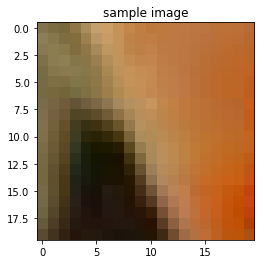

In [8]:
img_num =56
a = trainDataset_20[0][img_num]
a = np.transpose(a, axes = [1,2,0])+128/255.
plt.imshow(a)
plt.title("sample image")
plt.show()

In [9]:
# new=[]
# for k in range(70000):
#     a=trainDataset_20[0][k]
#     a=np.transpose(a, axes = [1,2,0])
#     lx = np.gradient(img0, axis=0)
#     ly = np.gradient(img0, axis=1)
#     t=np.sum(lx**2+ly**2)/400
#     if t>0.1:
#         a=new
#         new.append(a)
# print(new[0][1].shape)

In [10]:
# test_16_center=np.zeros((20000,3,16,16))
# for k in range(10000):
#     test_16_center[k,:,:,:]=testDataset_20[0][k,:,2:18,2:18]
# testDataset_16_center=[]
# for k in range(20000):
#     a=test_16_center
#     testDataset_16_center.append(a)
# f2=open('testDataset_16_center','wb')
# pickle.dump(testDataset_16_center,f2)
# f2.close()
# img_num=7777
# img=testDataset_16_center[0][img_num]
# img=np.transpose(img, axes = [1,2,0])
# plt.imshow(img)

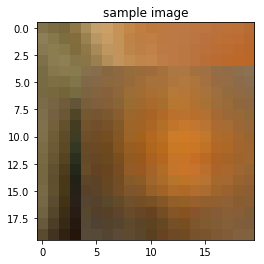

In [11]:
f2=open('train_20_new_2','rb')
train_20_new=pickle.load(f2)
f2.close
img_num =56
a = train_20_new[0][img_num]
a = np.transpose(a, axes = [1,2,0])+128/255.
plt.imshow(a)
plt.title("sample image")
plt.show()

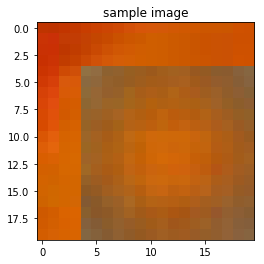

In [12]:
f3=open('validation_20_new_2','rb')
validation_20_new=pickle.load(f3)
f3.close
img_num =6666
a = train_20_new[0][img_num]
a = np.transpose(a, axes = [1,2,0])+128/255.
plt.imshow(a)
plt.title("sample image")
plt.show()

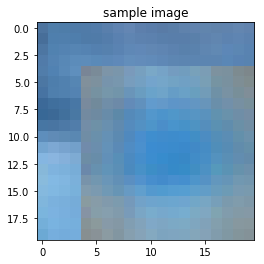

In [41]:
f4=open('test_20_new_2','rb')
test_20_new=pickle.load(f4)
f4.close
img_num =777
a = test_20_new[0][img_num]
a = np.transpose(a, axes = [1,2,0])+128/255.
plt.imshow(a)
plt.title("sample image")
plt.show()

In [14]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [15]:
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, image, label,  transforms=None):   # initial logic happens like transform

        self.image_masks = image
        self.transforms = transforms
        self.label = label
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):
        image = self.image_masks[index]
        label = self.label[index]
        sample = {'img': image, 'label': label}
        if transforms:
            sample = self.transforms(sample)            
        return sample

train_dataset = CustomDataset(train_20_new[0],trainDataset_20[0], transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(validation_20_new[0],valiDataset_20[0], transforms=transforms.Compose([Flip(),ToTensor()]))



In [16]:
print(valiDataset_20[0].shape)

(10000, 3, 20, 20)


In [51]:
################################################ [TODO] ###################################################
# Create a UNET object. Input channels = 3, output channels = 1
net = UNet1(3,1);

In [52]:
################################################ [TODO] ###################################################
# This function is used to evaluate the network after each epoch of training
# Input: network and validation dataset
# Output: average dice_coeff
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    for i, b in enumerate(dataset):
        img = b['img']
        img = img.type(torch.FloatTensor);
        label = b['label']
        label = label.type(torch.FloatTensor);
        ################################################ [TODO] ################################################### 
        # Feed in the image to get predicted mask
        pred_img = net.forward(img)
        tot += mse_coeff(pred_img,label);
    return tot / (i + 1)

In [53]:
################################################ [TODO] ###################################################
# Specify number of epochs, image scale factor, batch size and learning rate
epochs = 6# i.e, 4
batch_size = 50 # i.e, 16
lr = 0.01        # i.e, 0.01
lr_lambda = lambda epoch: 0.95 ** epoch
N_train = len(train_20_new)
model_save_path = './model0/'  # directory to same the model after each epoch. 


################################################ [TODO] ###################################################
# Define an optimizer for your model.
# Pytorch has built-in package called optim. Most commonly used methods are already supported.
# Here we use stochastic gradient descent to optimize
# For usage of SGD, you can read https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html
# Also you can use ADAM as the optimizer
# For usage of ADAM, you can read https://www.programcreek.com/python/example/92667/torch.optim.Adam

optimizer = optim.SGD(net.parameters(), lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

#OR optimizer = optim.Adam(...)


# The loss function we use is binary cross entropy: nn.BCELoss()
#criterion = nn.MSELoss()
# note that although we want to use DICE for evaluation, we use BCELoss for training in this example

################################################ [TODO] ###################################################
# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    scheduler.step()
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    epoch_loss = 0

    for i, b in enumerate(train_loader):
        ################################################ [TODO] ###################################################
        # Get images and masks from each batch
        imgs = b['img']
        imgs = imgs.type(torch.FloatTensor);
        ################################################ [TODO] ###################################################
        # Feed your images into the network
        img_pred = net.forward(imgs)
        # Flatten the predicted masks and true masks. For example, A_flat = A.(-1)
        label = b['label']
        ################################################ [TODO] ###################################################
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        #loss = criterion(img_pred_flat, imgs_flat)
        loss = grad_loss(img_pred, label, epoch)
        epoch_loss += loss.item()

        print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))

        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. 
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. 
        # These are accumulated into x.grad for every parameter x
        # x.grad += dloss/dx
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad. 
        # x += -lr * x.grad
        optimizer.step()

    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    ################################################ [TODO] ###################################################
    # Perform validation with eval_net() on the validation data
    val_dice = eval_net(net, val_loader)
    print('Validation Dice Coeff: {}'.format(val_dice))
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

Starting epoch 1/6.
0.0000 --- loss: 0.102233
0.0007 --- loss: 0.058811
0.0014 --- loss: 0.044739
0.0021 --- loss: 0.029092
0.0029 --- loss: 0.028201
0.0036 --- loss: 0.027460
0.0043 --- loss: 0.028091
0.0050 --- loss: 0.022436
0.0057 --- loss: 0.025928
0.0064 --- loss: 0.040943
0.0071 --- loss: 0.027735
0.0079 --- loss: 0.020538
0.0086 --- loss: 0.017332
0.0093 --- loss: 0.018674
0.0100 --- loss: 0.015793
0.0107 --- loss: 0.028105
0.0114 --- loss: 0.017223
0.0121 --- loss: 0.019918
0.0129 --- loss: 0.015826
0.0136 --- loss: 0.018741
0.0143 --- loss: 0.013222
0.0150 --- loss: 0.019047
0.0157 --- loss: 0.013290
0.0164 --- loss: 0.013961
0.0171 --- loss: 0.016354
0.0179 --- loss: 0.016354
0.0186 --- loss: 0.023965
0.0193 --- loss: 0.017320
0.0200 --- loss: 0.018289
0.0207 --- loss: 0.012708
0.0214 --- loss: 0.015535
0.0221 --- loss: 0.018392
0.0229 --- loss: 0.021235
0.0236 --- loss: 0.015423
0.0243 --- loss: 0.013207
0.0250 --- loss: 0.017113
0.0257 --- loss: 0.012321
0.0264 --- loss: 0

0.2250 --- loss: 0.017003
0.2257 --- loss: 0.010680
0.2264 --- loss: 0.012580
0.2271 --- loss: 0.009927
0.2279 --- loss: 0.007205
0.2286 --- loss: 0.008061
0.2293 --- loss: 0.009721
0.2300 --- loss: 0.016716
0.2307 --- loss: 0.009252
0.2314 --- loss: 0.009454
0.2321 --- loss: 0.008734
0.2329 --- loss: 0.007730
0.2336 --- loss: 0.014030
0.2343 --- loss: 0.010453
0.2350 --- loss: 0.010597
0.2357 --- loss: 0.008162
0.2364 --- loss: 0.006523
0.2371 --- loss: 0.009527
0.2379 --- loss: 0.007713
0.2386 --- loss: 0.011590
0.2393 --- loss: 0.013927
0.2400 --- loss: 0.013098
0.2407 --- loss: 0.012223
0.2414 --- loss: 0.008182
0.2421 --- loss: 0.009740
0.2429 --- loss: 0.007870
0.2436 --- loss: 0.009525
0.2443 --- loss: 0.009124
0.2450 --- loss: 0.008683
0.2457 --- loss: 0.009795
0.2464 --- loss: 0.007178
0.2471 --- loss: 0.009156
0.2479 --- loss: 0.010600
0.2486 --- loss: 0.006099
0.2493 --- loss: 0.012078
0.2500 --- loss: 0.011869
0.2507 --- loss: 0.010233
0.2514 --- loss: 0.009393
0.2521 --- l

0.4507 --- loss: 0.009262
0.4514 --- loss: 0.007464
0.4521 --- loss: 0.009208
0.4529 --- loss: 0.006079
0.4536 --- loss: 0.010580
0.4543 --- loss: 0.010740
0.4550 --- loss: 0.016451
0.4557 --- loss: 0.009729
0.4564 --- loss: 0.008710
0.4571 --- loss: 0.010891
0.4579 --- loss: 0.008064
0.4586 --- loss: 0.009580
0.4593 --- loss: 0.006903
0.4600 --- loss: 0.008634
0.4607 --- loss: 0.008477
0.4614 --- loss: 0.010929
0.4621 --- loss: 0.013012
0.4629 --- loss: 0.006585
0.4636 --- loss: 0.007055
0.4643 --- loss: 0.008943
0.4650 --- loss: 0.013091
0.4657 --- loss: 0.008530
0.4664 --- loss: 0.009965
0.4671 --- loss: 0.010646
0.4679 --- loss: 0.007511
0.4686 --- loss: 0.012433
0.4693 --- loss: 0.010417
0.4700 --- loss: 0.008572
0.4707 --- loss: 0.008320
0.4714 --- loss: 0.012689
0.4721 --- loss: 0.010921
0.4729 --- loss: 0.008308
0.4736 --- loss: 0.008214
0.4743 --- loss: 0.007231
0.4750 --- loss: 0.004402
0.4757 --- loss: 0.008273
0.4764 --- loss: 0.010443
0.4771 --- loss: 0.008362
0.4779 --- l

0.6764 --- loss: 0.010285
0.6771 --- loss: 0.008220
0.6779 --- loss: 0.007789
0.6786 --- loss: 0.007206
0.6793 --- loss: 0.013010
0.6800 --- loss: 0.009879
0.6807 --- loss: 0.012075
0.6814 --- loss: 0.008885
0.6821 --- loss: 0.011197
0.6829 --- loss: 0.005680
0.6836 --- loss: 0.012696
0.6843 --- loss: 0.005841
0.6850 --- loss: 0.012103
0.6857 --- loss: 0.012886
0.6864 --- loss: 0.007281
0.6871 --- loss: 0.012081
0.6879 --- loss: 0.012764
0.6886 --- loss: 0.007361
0.6893 --- loss: 0.009778
0.6900 --- loss: 0.012168
0.6907 --- loss: 0.007676
0.6914 --- loss: 0.008386
0.6921 --- loss: 0.011632
0.6929 --- loss: 0.007361
0.6936 --- loss: 0.008635
0.6943 --- loss: 0.014645
0.6950 --- loss: 0.009486
0.6957 --- loss: 0.009330
0.6964 --- loss: 0.008490
0.6971 --- loss: 0.012625
0.6979 --- loss: 0.015302
0.6986 --- loss: 0.010336
0.6993 --- loss: 0.010839
0.7000 --- loss: 0.010190
0.7007 --- loss: 0.009178
0.7014 --- loss: 0.006763
0.7021 --- loss: 0.011116
0.7029 --- loss: 0.009267
0.7036 --- l

0.9021 --- loss: 0.009210
0.9029 --- loss: 0.008990
0.9036 --- loss: 0.007683
0.9043 --- loss: 0.007940
0.9050 --- loss: 0.012401
0.9057 --- loss: 0.008096
0.9064 --- loss: 0.011988
0.9071 --- loss: 0.008167
0.9079 --- loss: 0.007753
0.9086 --- loss: 0.012321
0.9093 --- loss: 0.012813
0.9100 --- loss: 0.006604
0.9107 --- loss: 0.009616
0.9114 --- loss: 0.009343
0.9121 --- loss: 0.008586
0.9129 --- loss: 0.005934
0.9136 --- loss: 0.012548
0.9143 --- loss: 0.011330
0.9150 --- loss: 0.013217
0.9157 --- loss: 0.007486
0.9164 --- loss: 0.008716
0.9171 --- loss: 0.011943
0.9179 --- loss: 0.008863
0.9186 --- loss: 0.012108
0.9193 --- loss: 0.010949
0.9200 --- loss: 0.005947
0.9207 --- loss: 0.007520
0.9214 --- loss: 0.013899
0.9221 --- loss: 0.007296
0.9229 --- loss: 0.008844
0.9236 --- loss: 0.016874
0.9243 --- loss: 0.007178
0.9250 --- loss: 0.007507
0.9257 --- loss: 0.009728
0.9264 --- loss: 0.008800
0.9271 --- loss: 0.006784
0.9279 --- loss: 0.006220
0.9286 --- loss: 0.004575
0.9293 --- l

0.1236 --- loss: 0.006251
0.1243 --- loss: 0.005208
0.1250 --- loss: 0.009751
0.1257 --- loss: 0.008244
0.1264 --- loss: 0.007693
0.1271 --- loss: 0.006440
0.1279 --- loss: 0.009596
0.1286 --- loss: 0.008259
0.1293 --- loss: 0.009443
0.1300 --- loss: 0.006359
0.1307 --- loss: 0.008157
0.1314 --- loss: 0.012067
0.1321 --- loss: 0.008942
0.1329 --- loss: 0.005530
0.1336 --- loss: 0.006617
0.1343 --- loss: 0.005159
0.1350 --- loss: 0.006600
0.1357 --- loss: 0.007863
0.1364 --- loss: 0.006793
0.1371 --- loss: 0.007433
0.1379 --- loss: 0.012342
0.1386 --- loss: 0.005543
0.1393 --- loss: 0.004551
0.1400 --- loss: 0.007593
0.1407 --- loss: 0.006218
0.1414 --- loss: 0.009922
0.1421 --- loss: 0.007372
0.1429 --- loss: 0.008542
0.1436 --- loss: 0.006228
0.1443 --- loss: 0.007277
0.1450 --- loss: 0.009190
0.1457 --- loss: 0.008228
0.1464 --- loss: 0.008143
0.1471 --- loss: 0.004354
0.1479 --- loss: 0.006436
0.1486 --- loss: 0.005575
0.1493 --- loss: 0.011010
0.1500 --- loss: 0.007660
0.1507 --- l

0.3493 --- loss: 0.005031
0.3500 --- loss: 0.006715
0.3507 --- loss: 0.009368
0.3514 --- loss: 0.012988
0.3521 --- loss: 0.009718
0.3529 --- loss: 0.004879
0.3536 --- loss: 0.009223
0.3543 --- loss: 0.012906
0.3550 --- loss: 0.004844
0.3557 --- loss: 0.007883
0.3564 --- loss: 0.007349
0.3571 --- loss: 0.007290
0.3579 --- loss: 0.005507
0.3586 --- loss: 0.008705
0.3593 --- loss: 0.008795
0.3600 --- loss: 0.005523
0.3607 --- loss: 0.005090
0.3614 --- loss: 0.006950
0.3621 --- loss: 0.007620
0.3629 --- loss: 0.007277
0.3636 --- loss: 0.007647
0.3643 --- loss: 0.006034
0.3650 --- loss: 0.007691
0.3657 --- loss: 0.006087
0.3664 --- loss: 0.007118
0.3671 --- loss: 0.005809
0.3679 --- loss: 0.009203
0.3686 --- loss: 0.007235
0.3693 --- loss: 0.009827
0.3700 --- loss: 0.005586
0.3707 --- loss: 0.006782
0.3714 --- loss: 0.007894
0.3721 --- loss: 0.005525
0.3729 --- loss: 0.008017
0.3736 --- loss: 0.005958
0.3743 --- loss: 0.003008
0.3750 --- loss: 0.008163
0.3757 --- loss: 0.008006
0.3764 --- l

0.5750 --- loss: 0.007745
0.5757 --- loss: 0.014928
0.5764 --- loss: 0.006796
0.5771 --- loss: 0.006384
0.5779 --- loss: 0.008320
0.5786 --- loss: 0.013302
0.5793 --- loss: 0.007878
0.5800 --- loss: 0.007682
0.5807 --- loss: 0.006565
0.5814 --- loss: 0.006681
0.5821 --- loss: 0.009917
0.5829 --- loss: 0.011307
0.5836 --- loss: 0.006462
0.5843 --- loss: 0.008333
0.5850 --- loss: 0.006689
0.5857 --- loss: 0.008420
0.5864 --- loss: 0.005034
0.5871 --- loss: 0.007227
0.5879 --- loss: 0.007148
0.5886 --- loss: 0.006205
0.5893 --- loss: 0.011953
0.5900 --- loss: 0.006656
0.5907 --- loss: 0.007981
0.5914 --- loss: 0.007132
0.5921 --- loss: 0.004469
0.5929 --- loss: 0.007305
0.5936 --- loss: 0.007180
0.5943 --- loss: 0.005066
0.5950 --- loss: 0.009811
0.5957 --- loss: 0.010579
0.5964 --- loss: 0.005813
0.5971 --- loss: 0.004945
0.5979 --- loss: 0.006712
0.5986 --- loss: 0.012145
0.5993 --- loss: 0.010080
0.6000 --- loss: 0.012381
0.6007 --- loss: 0.005764
0.6014 --- loss: 0.007145
0.6021 --- l

0.8007 --- loss: 0.008873
0.8014 --- loss: 0.005907
0.8021 --- loss: 0.007099
0.8029 --- loss: 0.004732
0.8036 --- loss: 0.008822
0.8043 --- loss: 0.007312
0.8050 --- loss: 0.005878
0.8057 --- loss: 0.007925
0.8064 --- loss: 0.007528
0.8071 --- loss: 0.007107
0.8079 --- loss: 0.007411
0.8086 --- loss: 0.009858
0.8093 --- loss: 0.005959
0.8100 --- loss: 0.006387
0.8107 --- loss: 0.009100
0.8114 --- loss: 0.005677
0.8121 --- loss: 0.011093
0.8129 --- loss: 0.006177
0.8136 --- loss: 0.006157
0.8143 --- loss: 0.009712
0.8150 --- loss: 0.007775
0.8157 --- loss: 0.007814
0.8164 --- loss: 0.008638
0.8171 --- loss: 0.004587
0.8179 --- loss: 0.012591
0.8186 --- loss: 0.006706
0.8193 --- loss: 0.006183
0.8200 --- loss: 0.004571
0.8207 --- loss: 0.011006
0.8214 --- loss: 0.007279
0.8221 --- loss: 0.004937
0.8229 --- loss: 0.008436
0.8236 --- loss: 0.004978
0.8243 --- loss: 0.006763
0.8250 --- loss: 0.007184
0.8257 --- loss: 0.008420
0.8264 --- loss: 0.008171
0.8271 --- loss: 0.012420
0.8279 --- l

0.0221 --- loss: 0.005918
0.0229 --- loss: 0.007447
0.0236 --- loss: 0.007606
0.0243 --- loss: 0.007375
0.0250 --- loss: 0.006349
0.0257 --- loss: 0.004523
0.0264 --- loss: 0.007332
0.0271 --- loss: 0.006692
0.0279 --- loss: 0.004328
0.0286 --- loss: 0.004954
0.0293 --- loss: 0.013924
0.0300 --- loss: 0.004974
0.0307 --- loss: 0.007072
0.0314 --- loss: 0.007136
0.0321 --- loss: 0.002729
0.0329 --- loss: 0.004271
0.0336 --- loss: 0.011629
0.0343 --- loss: 0.004898
0.0350 --- loss: 0.003447
0.0357 --- loss: 0.008307
0.0364 --- loss: 0.005732
0.0371 --- loss: 0.004836
0.0379 --- loss: 0.010208
0.0386 --- loss: 0.004674
0.0393 --- loss: 0.006614
0.0400 --- loss: 0.006849
0.0407 --- loss: 0.007129
0.0414 --- loss: 0.004440
0.0421 --- loss: 0.005204
0.0429 --- loss: 0.005560
0.0436 --- loss: 0.004679
0.0443 --- loss: 0.003227
0.0450 --- loss: 0.007533
0.0457 --- loss: 0.007924
0.0464 --- loss: 0.011985
0.0471 --- loss: 0.007761
0.0479 --- loss: 0.007695
0.0486 --- loss: 0.005777
0.0493 --- l

0.2479 --- loss: 0.009791
0.2486 --- loss: 0.007985
0.2493 --- loss: 0.004970
0.2500 --- loss: 0.006003
0.2507 --- loss: 0.006076
0.2514 --- loss: 0.005728
0.2521 --- loss: 0.009099
0.2529 --- loss: 0.005753
0.2536 --- loss: 0.009569
0.2543 --- loss: 0.007388
0.2550 --- loss: 0.006507
0.2557 --- loss: 0.007895
0.2564 --- loss: 0.002499
0.2571 --- loss: 0.006535
0.2579 --- loss: 0.007555
0.2586 --- loss: 0.004053
0.2593 --- loss: 0.006229
0.2600 --- loss: 0.006998
0.2607 --- loss: 0.006287
0.2614 --- loss: 0.005330
0.2621 --- loss: 0.005614
0.2629 --- loss: 0.007868
0.2636 --- loss: 0.003792
0.2643 --- loss: 0.011233
0.2650 --- loss: 0.007562
0.2657 --- loss: 0.003264
0.2664 --- loss: 0.006973
0.2671 --- loss: 0.006575
0.2679 --- loss: 0.004629
0.2686 --- loss: 0.005500
0.2693 --- loss: 0.008457
0.2700 --- loss: 0.008870
0.2707 --- loss: 0.005453
0.2714 --- loss: 0.002977
0.2721 --- loss: 0.008175
0.2729 --- loss: 0.006515
0.2736 --- loss: 0.007750
0.2743 --- loss: 0.003772
0.2750 --- l

0.4736 --- loss: 0.005847
0.4743 --- loss: 0.003697
0.4750 --- loss: 0.003650
0.4757 --- loss: 0.005786
0.4764 --- loss: 0.005966
0.4771 --- loss: 0.005254
0.4779 --- loss: 0.004090
0.4786 --- loss: 0.004911
0.4793 --- loss: 0.009344
0.4800 --- loss: 0.004637
0.4807 --- loss: 0.007949
0.4814 --- loss: 0.003371
0.4821 --- loss: 0.007409
0.4829 --- loss: 0.005837
0.4836 --- loss: 0.006705
0.4843 --- loss: 0.004122
0.4850 --- loss: 0.003807
0.4857 --- loss: 0.004223
0.4864 --- loss: 0.008235
0.4871 --- loss: 0.005958
0.4879 --- loss: 0.004848
0.4886 --- loss: 0.003680
0.4893 --- loss: 0.005419
0.4900 --- loss: 0.006601
0.4907 --- loss: 0.007462
0.4914 --- loss: 0.002764
0.4921 --- loss: 0.004743
0.4929 --- loss: 0.009909
0.4936 --- loss: 0.005899
0.4943 --- loss: 0.003915
0.4950 --- loss: 0.007743
0.4957 --- loss: 0.008724
0.4964 --- loss: 0.005288
0.4971 --- loss: 0.006836
0.4979 --- loss: 0.008806
0.4986 --- loss: 0.008075
0.4993 --- loss: 0.004074
0.5000 --- loss: 0.003412
0.5007 --- l

0.6993 --- loss: 0.005363
0.7000 --- loss: 0.006301
0.7007 --- loss: 0.007202
0.7014 --- loss: 0.006810
0.7021 --- loss: 0.009888
0.7029 --- loss: 0.010314
0.7036 --- loss: 0.005863
0.7043 --- loss: 0.005022
0.7050 --- loss: 0.004588
0.7057 --- loss: 0.008085
0.7064 --- loss: 0.004884
0.7071 --- loss: 0.003800
0.7079 --- loss: 0.004931
0.7086 --- loss: 0.006220
0.7093 --- loss: 0.005013
0.7100 --- loss: 0.006975
0.7107 --- loss: 0.006255
0.7114 --- loss: 0.005897
0.7121 --- loss: 0.006402
0.7129 --- loss: 0.006197
0.7136 --- loss: 0.005140
0.7143 --- loss: 0.005785
0.7150 --- loss: 0.006058
0.7157 --- loss: 0.005442
0.7164 --- loss: 0.005553
0.7171 --- loss: 0.007824
0.7179 --- loss: 0.004439
0.7186 --- loss: 0.003948
0.7193 --- loss: 0.004310
0.7200 --- loss: 0.009758
0.7207 --- loss: 0.007816
0.7214 --- loss: 0.004964
0.7221 --- loss: 0.006521
0.7229 --- loss: 0.005944
0.7236 --- loss: 0.005704
0.7243 --- loss: 0.007572
0.7250 --- loss: 0.004599
0.7257 --- loss: 0.006580
0.7264 --- l

0.9250 --- loss: 0.006203
0.9257 --- loss: 0.006247
0.9264 --- loss: 0.002939
0.9271 --- loss: 0.006914
0.9279 --- loss: 0.005958
0.9286 --- loss: 0.002444
0.9293 --- loss: 0.006766
0.9300 --- loss: 0.006412
0.9307 --- loss: 0.005687
0.9314 --- loss: 0.005103
0.9321 --- loss: 0.004246
0.9329 --- loss: 0.005395
0.9336 --- loss: 0.007818
0.9343 --- loss: 0.009015
0.9350 --- loss: 0.006786
0.9357 --- loss: 0.003800
0.9364 --- loss: 0.006792
0.9371 --- loss: 0.006030
0.9379 --- loss: 0.005129
0.9386 --- loss: 0.005935
0.9393 --- loss: 0.007862
0.9400 --- loss: 0.005188
0.9407 --- loss: 0.005968
0.9414 --- loss: 0.007055
0.9421 --- loss: 0.007592
0.9429 --- loss: 0.003481
0.9436 --- loss: 0.004863
0.9443 --- loss: 0.004501
0.9450 --- loss: 0.006040
0.9457 --- loss: 0.004336
0.9464 --- loss: 0.007006
0.9471 --- loss: 0.005424
0.9479 --- loss: 0.004894
0.9486 --- loss: 0.009483
0.9493 --- loss: 0.009555
0.9500 --- loss: 0.006128
0.9507 --- loss: 0.009586
0.9514 --- loss: 0.004932
0.9521 --- l

0.1464 --- loss: 0.005731
0.1471 --- loss: 0.008200
0.1479 --- loss: 0.005180
0.1486 --- loss: 0.004783
0.1493 --- loss: 0.003691
0.1500 --- loss: 0.004748
0.1507 --- loss: 0.003524
0.1514 --- loss: 0.008832
0.1521 --- loss: 0.004662
0.1529 --- loss: 0.006189
0.1536 --- loss: 0.005750
0.1543 --- loss: 0.005694
0.1550 --- loss: 0.004326
0.1557 --- loss: 0.004194
0.1564 --- loss: 0.004194
0.1571 --- loss: 0.004924
0.1579 --- loss: 0.004292
0.1586 --- loss: 0.003349
0.1593 --- loss: 0.003436
0.1600 --- loss: 0.004241
0.1607 --- loss: 0.005242
0.1614 --- loss: 0.003491
0.1621 --- loss: 0.005527
0.1629 --- loss: 0.003257
0.1636 --- loss: 0.003209
0.1643 --- loss: 0.004716
0.1650 --- loss: 0.004228
0.1657 --- loss: 0.004372
0.1664 --- loss: 0.003593
0.1671 --- loss: 0.005143
0.1679 --- loss: 0.004021
0.1686 --- loss: 0.004797
0.1693 --- loss: 0.006082
0.1700 --- loss: 0.003510
0.1707 --- loss: 0.003865
0.1714 --- loss: 0.003717
0.1721 --- loss: 0.003801
0.1729 --- loss: 0.004684
0.1736 --- l

0.3721 --- loss: 0.003455
0.3729 --- loss: 0.003820
0.3736 --- loss: 0.009904
0.3743 --- loss: 0.003970
0.3750 --- loss: 0.006486
0.3757 --- loss: 0.008782
0.3764 --- loss: 0.005200
0.3771 --- loss: 0.003657
0.3779 --- loss: 0.002979
0.3786 --- loss: 0.006382
0.3793 --- loss: 0.005376
0.3800 --- loss: 0.004643
0.3807 --- loss: 0.003861
0.3814 --- loss: 0.005498
0.3821 --- loss: 0.004152
0.3829 --- loss: 0.006225
0.3836 --- loss: 0.005821
0.3843 --- loss: 0.004528
0.3850 --- loss: 0.005644
0.3857 --- loss: 0.004694
0.3864 --- loss: 0.005716
0.3871 --- loss: 0.003671
0.3879 --- loss: 0.006510
0.3886 --- loss: 0.004532
0.3893 --- loss: 0.006789
0.3900 --- loss: 0.003472
0.3907 --- loss: 0.004565
0.3914 --- loss: 0.003301
0.3921 --- loss: 0.004357
0.3929 --- loss: 0.004192
0.3936 --- loss: 0.004556
0.3943 --- loss: 0.003791
0.3950 --- loss: 0.003504
0.3957 --- loss: 0.006812
0.3964 --- loss: 0.004110
0.3971 --- loss: 0.004676
0.3979 --- loss: 0.003712
0.3986 --- loss: 0.003646
0.3993 --- l

0.5979 --- loss: 0.005508
0.5986 --- loss: 0.003160
0.5993 --- loss: 0.006201
0.6000 --- loss: 0.007699
0.6007 --- loss: 0.006127
0.6014 --- loss: 0.005353
0.6021 --- loss: 0.009918
0.6029 --- loss: 0.004625
0.6036 --- loss: 0.003931
0.6043 --- loss: 0.002355
0.6050 --- loss: 0.006247
0.6057 --- loss: 0.005670
0.6064 --- loss: 0.002795
0.6071 --- loss: 0.003740
0.6079 --- loss: 0.004490
0.6086 --- loss: 0.003563
0.6093 --- loss: 0.005262
0.6100 --- loss: 0.004461
0.6107 --- loss: 0.004157
0.6114 --- loss: 0.006498
0.6121 --- loss: 0.004496
0.6129 --- loss: 0.007144
0.6136 --- loss: 0.003358
0.6143 --- loss: 0.004207
0.6150 --- loss: 0.005120
0.6157 --- loss: 0.004753
0.6164 --- loss: 0.007412
0.6171 --- loss: 0.005150
0.6179 --- loss: 0.005631
0.6186 --- loss: 0.005116
0.6193 --- loss: 0.002989
0.6200 --- loss: 0.002797
0.6207 --- loss: 0.006955
0.6214 --- loss: 0.003588
0.6221 --- loss: 0.003302
0.6229 --- loss: 0.005518
0.6236 --- loss: 0.004489
0.6243 --- loss: 0.003237
0.6250 --- l

0.8236 --- loss: 0.003962
0.8243 --- loss: 0.008034
0.8250 --- loss: 0.004522
0.8257 --- loss: 0.003830
0.8264 --- loss: 0.003603
0.8271 --- loss: 0.004972
0.8279 --- loss: 0.003374
0.8286 --- loss: 0.007016
0.8293 --- loss: 0.005849
0.8300 --- loss: 0.007008
0.8307 --- loss: 0.003777
0.8314 --- loss: 0.003498
0.8321 --- loss: 0.004310
0.8329 --- loss: 0.005136
0.8336 --- loss: 0.003913
0.8343 --- loss: 0.006104
0.8350 --- loss: 0.007700
0.8357 --- loss: 0.004403
0.8364 --- loss: 0.006347
0.8371 --- loss: 0.004684
0.8379 --- loss: 0.005010
0.8386 --- loss: 0.004949
0.8393 --- loss: 0.004067
0.8400 --- loss: 0.004789
0.8407 --- loss: 0.005133
0.8414 --- loss: 0.005014
0.8421 --- loss: 0.003707
0.8429 --- loss: 0.003097
0.8436 --- loss: 0.002555
0.8443 --- loss: 0.004251
0.8450 --- loss: 0.004003
0.8457 --- loss: 0.008720
0.8464 --- loss: 0.004166
0.8471 --- loss: 0.005756
0.8479 --- loss: 0.003189
0.8486 --- loss: 0.005137
0.8493 --- loss: 0.004702
0.8500 --- loss: 0.003073
0.8507 --- l

0.0450 --- loss: 0.003640
0.0457 --- loss: 0.003698
0.0464 --- loss: 0.006464
0.0471 --- loss: 0.008318
0.0479 --- loss: 0.003692
0.0486 --- loss: 0.005146
0.0493 --- loss: 0.005530
0.0500 --- loss: 0.004330
0.0507 --- loss: 0.007149
0.0514 --- loss: 0.005794
0.0521 --- loss: 0.003698
0.0529 --- loss: 0.004760
0.0536 --- loss: 0.006092
0.0543 --- loss: 0.002753
0.0550 --- loss: 0.005617
0.0557 --- loss: 0.005929
0.0564 --- loss: 0.004850
0.0571 --- loss: 0.006524
0.0579 --- loss: 0.002591
0.0586 --- loss: 0.004372
0.0593 --- loss: 0.004866
0.0600 --- loss: 0.005015
0.0607 --- loss: 0.004953
0.0614 --- loss: 0.009052
0.0621 --- loss: 0.005177
0.0629 --- loss: 0.004091
0.0636 --- loss: 0.004998
0.0643 --- loss: 0.004433
0.0650 --- loss: 0.005286
0.0657 --- loss: 0.004880
0.0664 --- loss: 0.008357
0.0671 --- loss: 0.003421
0.0679 --- loss: 0.005885
0.0686 --- loss: 0.002576
0.0693 --- loss: 0.006596
0.0700 --- loss: 0.004570
0.0707 --- loss: 0.008409
0.0714 --- loss: 0.005450
0.0721 --- l

0.2707 --- loss: 0.004939
0.2714 --- loss: 0.004240
0.2721 --- loss: 0.011063
0.2729 --- loss: 0.005436
0.2736 --- loss: 0.004044
0.2743 --- loss: 0.007067
0.2750 --- loss: 0.004444
0.2757 --- loss: 0.006036
0.2764 --- loss: 0.004289
0.2771 --- loss: 0.004952
0.2779 --- loss: 0.004966
0.2786 --- loss: 0.005951
0.2793 --- loss: 0.004486
0.2800 --- loss: 0.006033
0.2807 --- loss: 0.003021
0.2814 --- loss: 0.006522
0.2821 --- loss: 0.006228
0.2829 --- loss: 0.006606
0.2836 --- loss: 0.004684
0.2843 --- loss: 0.005054
0.2850 --- loss: 0.004209
0.2857 --- loss: 0.009849
0.2864 --- loss: 0.002830
0.2871 --- loss: 0.002593
0.2879 --- loss: 0.003113
0.2886 --- loss: 0.003338
0.2893 --- loss: 0.004038
0.2900 --- loss: 0.005076
0.2907 --- loss: 0.004596
0.2914 --- loss: 0.003442
0.2921 --- loss: 0.004353
0.2929 --- loss: 0.006233
0.2936 --- loss: 0.005021
0.2943 --- loss: 0.002978
0.2950 --- loss: 0.004608
0.2957 --- loss: 0.004299
0.2964 --- loss: 0.004937
0.2971 --- loss: 0.003972
0.2979 --- l

0.4964 --- loss: 0.003839
0.4971 --- loss: 0.006036
0.4979 --- loss: 0.002831
0.4986 --- loss: 0.006441
0.4993 --- loss: 0.002379
0.5000 --- loss: 0.002769
0.5007 --- loss: 0.003962
0.5014 --- loss: 0.005822
0.5021 --- loss: 0.004060
0.5029 --- loss: 0.005574
0.5036 --- loss: 0.003796
0.5043 --- loss: 0.004025
0.5050 --- loss: 0.004843
0.5057 --- loss: 0.004024
0.5064 --- loss: 0.004528
0.5071 --- loss: 0.004622
0.5079 --- loss: 0.004567
0.5086 --- loss: 0.003977
0.5093 --- loss: 0.005574
0.5100 --- loss: 0.004491
0.5107 --- loss: 0.004351
0.5114 --- loss: 0.005651
0.5121 --- loss: 0.005355
0.5129 --- loss: 0.004126
0.5136 --- loss: 0.009433
0.5143 --- loss: 0.003905
0.5150 --- loss: 0.005593
0.5157 --- loss: 0.006346
0.5164 --- loss: 0.006939
0.5171 --- loss: 0.004338
0.5179 --- loss: 0.005361
0.5186 --- loss: 0.004944
0.5193 --- loss: 0.003239
0.5200 --- loss: 0.004144
0.5207 --- loss: 0.004185
0.5214 --- loss: 0.004570
0.5221 --- loss: 0.002526
0.5229 --- loss: 0.005105
0.5236 --- l

0.7221 --- loss: 0.007260
0.7229 --- loss: 0.004973
0.7236 --- loss: 0.003306
0.7243 --- loss: 0.005035
0.7250 --- loss: 0.006237
0.7257 --- loss: 0.006764
0.7264 --- loss: 0.004441
0.7271 --- loss: 0.003628
0.7279 --- loss: 0.003670
0.7286 --- loss: 0.004081
0.7293 --- loss: 0.005862
0.7300 --- loss: 0.005930
0.7307 --- loss: 0.004356
0.7314 --- loss: 0.005893
0.7321 --- loss: 0.004198
0.7329 --- loss: 0.004801
0.7336 --- loss: 0.003990
0.7343 --- loss: 0.004893
0.7350 --- loss: 0.002860
0.7357 --- loss: 0.003663
0.7364 --- loss: 0.002356
0.7371 --- loss: 0.004084
0.7379 --- loss: 0.003904
0.7386 --- loss: 0.005293
0.7393 --- loss: 0.003018
0.7400 --- loss: 0.005055
0.7407 --- loss: 0.005144
0.7414 --- loss: 0.003964
0.7421 --- loss: 0.005358
0.7429 --- loss: 0.004278
0.7436 --- loss: 0.007757
0.7443 --- loss: 0.006020
0.7450 --- loss: 0.003952
0.7457 --- loss: 0.004551
0.7464 --- loss: 0.005088
0.7471 --- loss: 0.003957
0.7479 --- loss: 0.005043
0.7486 --- loss: 0.003915
0.7493 --- l

0.9479 --- loss: 0.004622
0.9486 --- loss: 0.004657
0.9493 --- loss: 0.003714
0.9500 --- loss: 0.004819
0.9507 --- loss: 0.006018
0.9514 --- loss: 0.003617
0.9521 --- loss: 0.005435
0.9529 --- loss: 0.004445
0.9536 --- loss: 0.002977
0.9543 --- loss: 0.003825
0.9550 --- loss: 0.002322
0.9557 --- loss: 0.003346
0.9564 --- loss: 0.003128
0.9571 --- loss: 0.005643
0.9579 --- loss: 0.006573
0.9586 --- loss: 0.003637
0.9593 --- loss: 0.005888
0.9600 --- loss: 0.005736
0.9607 --- loss: 0.005845
0.9614 --- loss: 0.005182
0.9621 --- loss: 0.005266
0.9629 --- loss: 0.003923
0.9636 --- loss: 0.008062
0.9643 --- loss: 0.004138
0.9650 --- loss: 0.004530
0.9657 --- loss: 0.005843
0.9664 --- loss: 0.005359
0.9671 --- loss: 0.003182
0.9679 --- loss: 0.004111
0.9686 --- loss: 0.003984
0.9693 --- loss: 0.005585
0.9700 --- loss: 0.004215
0.9707 --- loss: 0.004732
0.9714 --- loss: 0.005885
0.9721 --- loss: 0.003072
0.9729 --- loss: 0.005314
0.9736 --- loss: 0.005227
0.9743 --- loss: 0.002379
0.9750 --- l

0.1693 --- loss: 0.006646
0.1700 --- loss: 0.005808
0.1707 --- loss: 0.003034
0.1714 --- loss: 0.004716
0.1721 --- loss: 0.003555
0.1729 --- loss: 0.002213
0.1736 --- loss: 0.004809
0.1743 --- loss: 0.005179
0.1750 --- loss: 0.004245
0.1757 --- loss: 0.001893
0.1764 --- loss: 0.003443
0.1771 --- loss: 0.004034
0.1779 --- loss: 0.005609
0.1786 --- loss: 0.004195
0.1793 --- loss: 0.003269
0.1800 --- loss: 0.007195
0.1807 --- loss: 0.005512
0.1814 --- loss: 0.003758
0.1821 --- loss: 0.004185
0.1829 --- loss: 0.006190
0.1836 --- loss: 0.003037
0.1843 --- loss: 0.004636
0.1850 --- loss: 0.004681
0.1857 --- loss: 0.004592
0.1864 --- loss: 0.006947
0.1871 --- loss: 0.003520
0.1879 --- loss: 0.004088
0.1886 --- loss: 0.006602
0.1893 --- loss: 0.004942
0.1900 --- loss: 0.005560
0.1907 --- loss: 0.006801
0.1914 --- loss: 0.004662
0.1921 --- loss: 0.005491
0.1929 --- loss: 0.004394
0.1936 --- loss: 0.003665
0.1943 --- loss: 0.007362
0.1950 --- loss: 0.004560
0.1957 --- loss: 0.007945
0.1964 --- l

0.3950 --- loss: 0.003269
0.3957 --- loss: 0.006048
0.3964 --- loss: 0.005666
0.3971 --- loss: 0.004266
0.3979 --- loss: 0.004205
0.3986 --- loss: 0.004956
0.3993 --- loss: 0.004281
0.4000 --- loss: 0.007219
0.4007 --- loss: 0.004115
0.4014 --- loss: 0.002208
0.4021 --- loss: 0.006274
0.4029 --- loss: 0.004813
0.4036 --- loss: 0.006842
0.4043 --- loss: 0.006269
0.4050 --- loss: 0.008743
0.4057 --- loss: 0.005951
0.4064 --- loss: 0.004623
0.4071 --- loss: 0.005312
0.4079 --- loss: 0.006611
0.4086 --- loss: 0.005789
0.4093 --- loss: 0.006929
0.4100 --- loss: 0.005116
0.4107 --- loss: 0.005864
0.4114 --- loss: 0.005420
0.4121 --- loss: 0.006957
0.4129 --- loss: 0.005882
0.4136 --- loss: 0.006743
0.4143 --- loss: 0.004101
0.4150 --- loss: 0.004850
0.4157 --- loss: 0.003674
0.4164 --- loss: 0.003737
0.4171 --- loss: 0.005807
0.4179 --- loss: 0.005487
0.4186 --- loss: 0.004344
0.4193 --- loss: 0.007747
0.4200 --- loss: 0.004459
0.4207 --- loss: 0.005983
0.4214 --- loss: 0.006845
0.4221 --- l

0.6207 --- loss: 0.004715
0.6214 --- loss: 0.004405
0.6221 --- loss: 0.002953
0.6229 --- loss: 0.008320
0.6236 --- loss: 0.008795
0.6243 --- loss: 0.007338
0.6250 --- loss: 0.002998
0.6257 --- loss: 0.006318
0.6264 --- loss: 0.004359
0.6271 --- loss: 0.005739
0.6279 --- loss: 0.005609
0.6286 --- loss: 0.004585
0.6293 --- loss: 0.004753
0.6300 --- loss: 0.006095
0.6307 --- loss: 0.006471
0.6314 --- loss: 0.005210
0.6321 --- loss: 0.002909
0.6329 --- loss: 0.003197
0.6336 --- loss: 0.003984
0.6343 --- loss: 0.005308
0.6350 --- loss: 0.003460
0.6357 --- loss: 0.005097
0.6364 --- loss: 0.004062
0.6371 --- loss: 0.005495
0.6379 --- loss: 0.003869
0.6386 --- loss: 0.004969
0.6393 --- loss: 0.005280
0.6400 --- loss: 0.006728
0.6407 --- loss: 0.006079
0.6414 --- loss: 0.006781
0.6421 --- loss: 0.005059
0.6429 --- loss: 0.005731
0.6436 --- loss: 0.006451
0.6443 --- loss: 0.003606
0.6450 --- loss: 0.003833
0.6457 --- loss: 0.003134
0.6464 --- loss: 0.003640
0.6471 --- loss: 0.004298
0.6479 --- l

0.8464 --- loss: 0.008651
0.8471 --- loss: 0.005264
0.8479 --- loss: 0.008103
0.8486 --- loss: 0.003358
0.8493 --- loss: 0.005790
0.8500 --- loss: 0.004969
0.8507 --- loss: 0.005677
0.8514 --- loss: 0.002452
0.8521 --- loss: 0.005424
0.8529 --- loss: 0.003693
0.8536 --- loss: 0.002877
0.8543 --- loss: 0.003735
0.8550 --- loss: 0.005514
0.8557 --- loss: 0.005342
0.8564 --- loss: 0.005255
0.8571 --- loss: 0.005797
0.8579 --- loss: 0.005827
0.8586 --- loss: 0.003599
0.8593 --- loss: 0.004407
0.8600 --- loss: 0.002465
0.8607 --- loss: 0.005775
0.8614 --- loss: 0.004842
0.8621 --- loss: 0.005145
0.8629 --- loss: 0.003000
0.8636 --- loss: 0.008364
0.8643 --- loss: 0.005239
0.8650 --- loss: 0.004054
0.8657 --- loss: 0.005024
0.8664 --- loss: 0.005463
0.8671 --- loss: 0.006535
0.8679 --- loss: 0.008390
0.8686 --- loss: 0.005402
0.8693 --- loss: 0.007219
0.8700 --- loss: 0.003887
0.8707 --- loss: 0.004947
0.8714 --- loss: 0.006620
0.8721 --- loss: 0.005332
0.8729 --- loss: 0.005695
0.8736 --- l

In [142]:
################################################ [TODO] ###################################################
# Define a function for prediction/testing
def predict_img(net,full_img):
    # set the mode of your network to evaluation
    net.eval()
    
    # convert from Height*Width*Channel TO Channel*Height*Width
    # convert numpy array to torch tensor 
    #Unsqueeze add an extra dimension
    X_img = torch.from_numpy(full_img).unsqueeze(0)
    X_img = X_img.type(torch.FloatTensor)
    with torch.no_grad():
        ################################################ [TODO] ###################################################
        # predict the masks 
        output_img = net.forward(X_img)
        output_img = output_img.squeeze(0)
    # For all pixels in predicted mask, set them to 1 if larger than out_threshold. Otherwise set them to 0
    return output_img

In [143]:
# You might need to use these functions in the following steps
# hwc_to_chw: Convert images from Height*Width*Channels to Channels*Height*Width
def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])

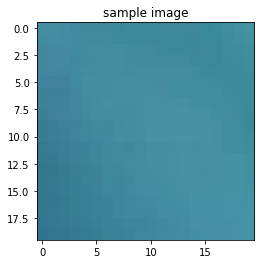

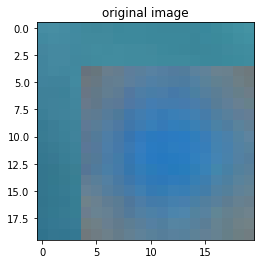

<Figure size 432x288 with 0 Axes>

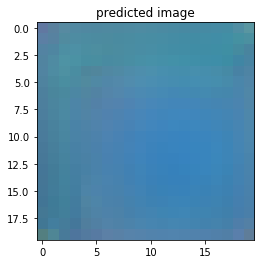

<Figure size 432x288 with 0 Axes>

In [326]:
# Plot original images and masks
#127/23/123/5
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage.filters import convolve as convolveim
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
imgnum=38124
a = trainDataset_20[0][imgnum]
a = np.transpose(a, axes = [1,2,0])+128/255.
plt.imshow(a)
plt.title("sample image")
plt.show()
orig_img = train_20_new[0][imgnum]
test_img = train_20_new[0][imgnum]
#test_img = np.zeros((3,16,16))
test_img_show = np.transpose(orig_img, axes=[1, 2, 0])+128/255.
#test_img_show = (test_img_show)*255#+128
#test_img_show = test_img_show.astype(int)
#print(test_img_show)
plt.imshow(test_img_show)
plt.title("original image")
plt.show()
#Predict a new image
pred_img = predict_img(net, test_img)
pred_img_show = np.transpose(pred_img, axes=[1, 2, 0])+128/255.
#pred_img_show = pred_img_show*255#+128
#pred_img_show = pred_img_show.type(torch.uint8)
plt.imshow(pred_img_show)
plt.title("predicted image")
plt.figure()
#print(pred_img_show)

In [50]:
###Saving Parameters 3 only MSE 4 MSE + GRad loss, 5 grad loss only
PATH = './model/modelparamsGradComp96.pth'
torch.save(net, PATH)

/Users/yuxuanqi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type UNet1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/yuxuanqi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type single_conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/yuxuanqi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type down. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/yuxuanqi/anaconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type up. It won't be checked for correctness upon loading.
  "type " + obj.__name__ +

In [54]:
# Loading parameters
PATH = './model/modelparamsGradComp96.pth'
net = torch.load(PATH)